In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import pyro
import seaborn as sns
import torch
import pyro.distributions as dist
from chirho.dynamical.handlers import LogTrajectory
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from pyro.infer import Predictive
from chirho.observational.handlers import condition
from chirho.dynamical.handlers import (LogTrajectory, StaticBatchObservation, StaticIntervention)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate

pyro.settings.set(module_local_params=True)

sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver



In [2]:
locds = lc.LocustDS(data_code = "15EQ20191202", 
                    start =40,
                    end = 70,)

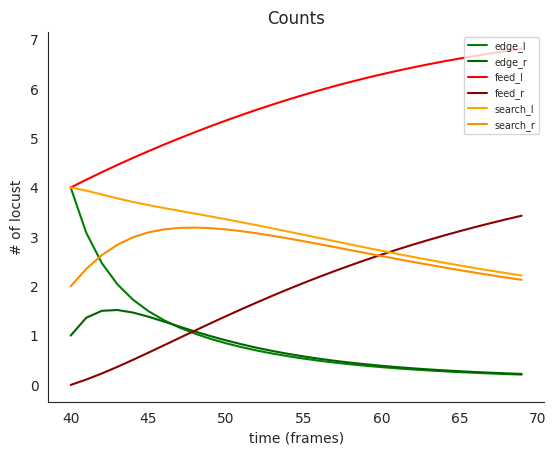

In [3]:
true_attraction = torch.tensor([0.01, 0.01, 0.01, 0.01, 0.01])
true_wander = torch.tensor([0.2, 0.1, 0.01, 0.05])


locds.simulate_trajectories(true_attraction=true_attraction,
                          true_wander=true_wander,
                          )

locds.plot_simulated_trajectories()

In [4]:
locds.get_prior_samples(num_samples = 150)

In [5]:
locds.run_inference("length", num_iterations= 1500,num_samples = 150, lr = 0.001)

In [6]:
locds.evaluate()

locds.rsquared

tensor(0.4081, dtype=torch.float64)

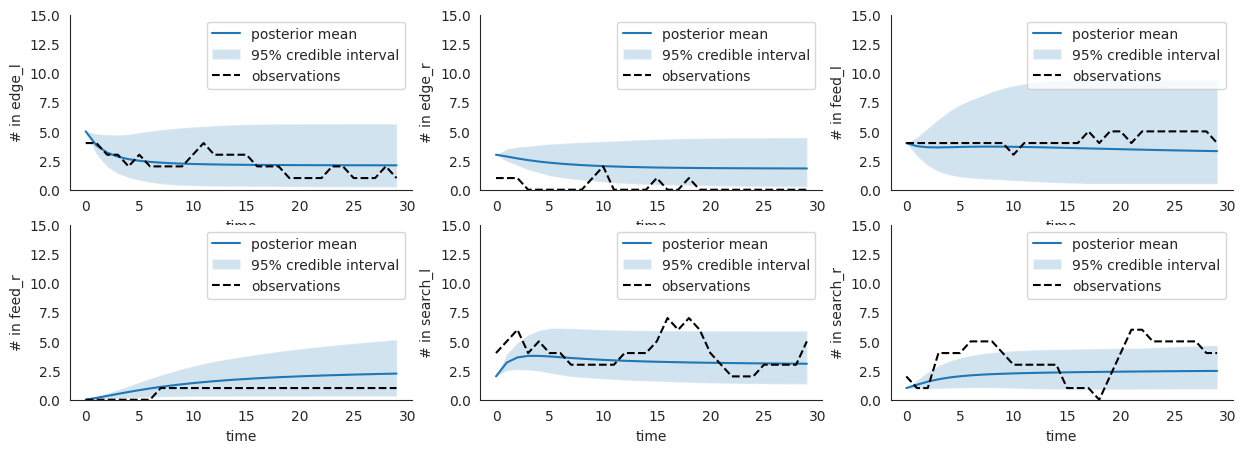

In [7]:
locds.posterior_check()

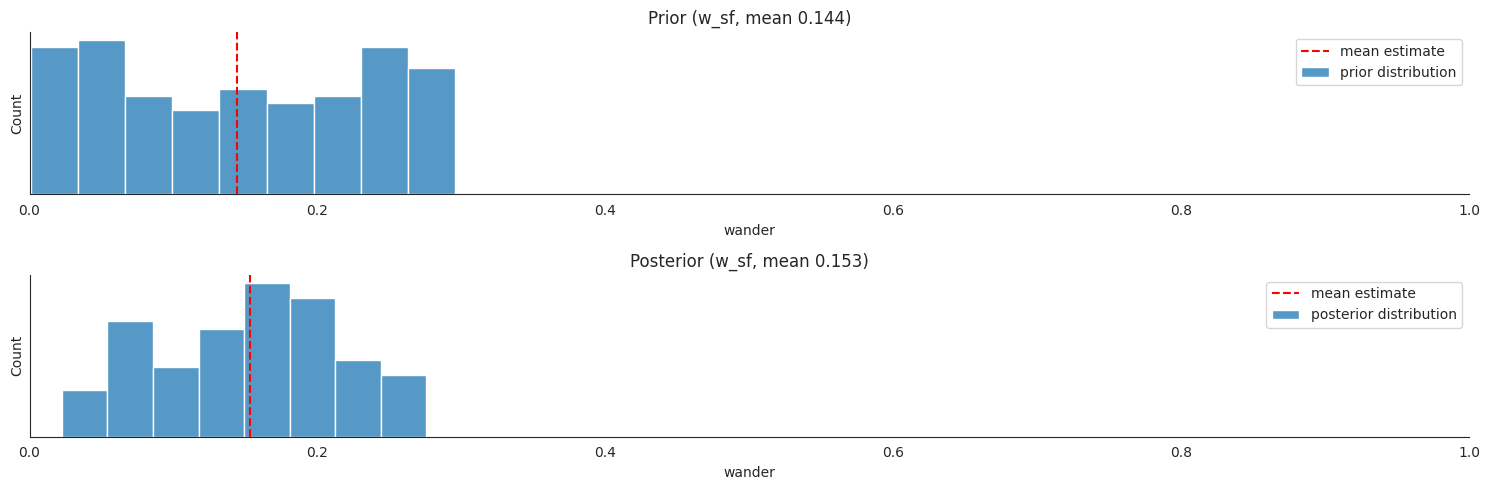

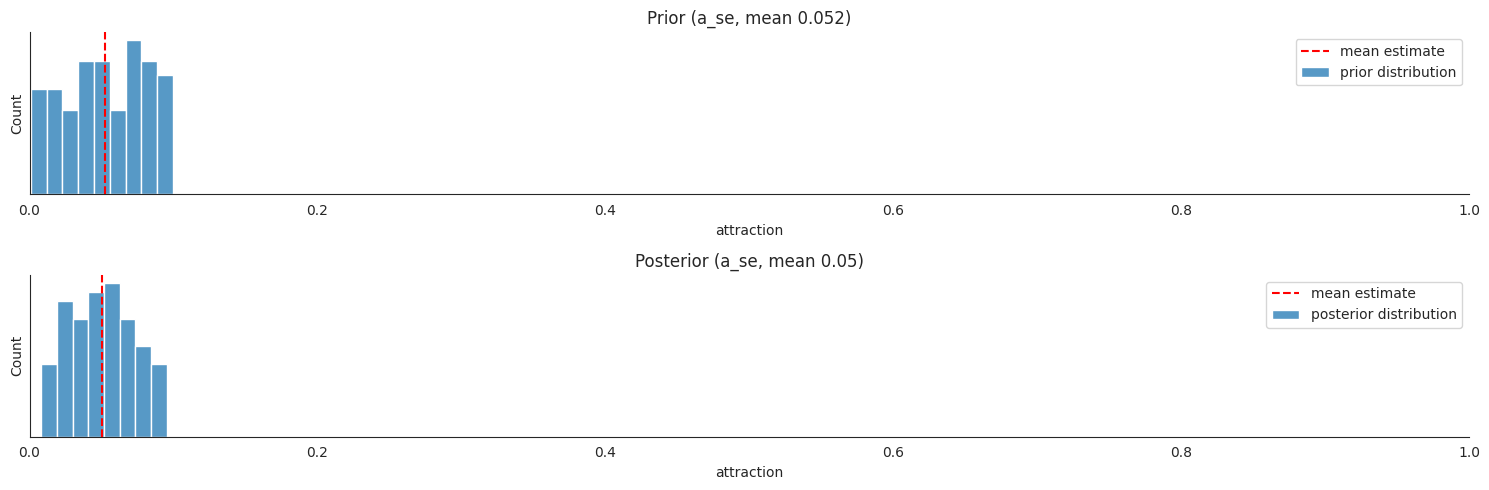

In [8]:
locds.plot_param_estimates(3,3)

In [11]:
locds.validate(validation_data_code = "15EQ20191205")


locds.validation.keys()



dict_keys(['15EQ20191205'])

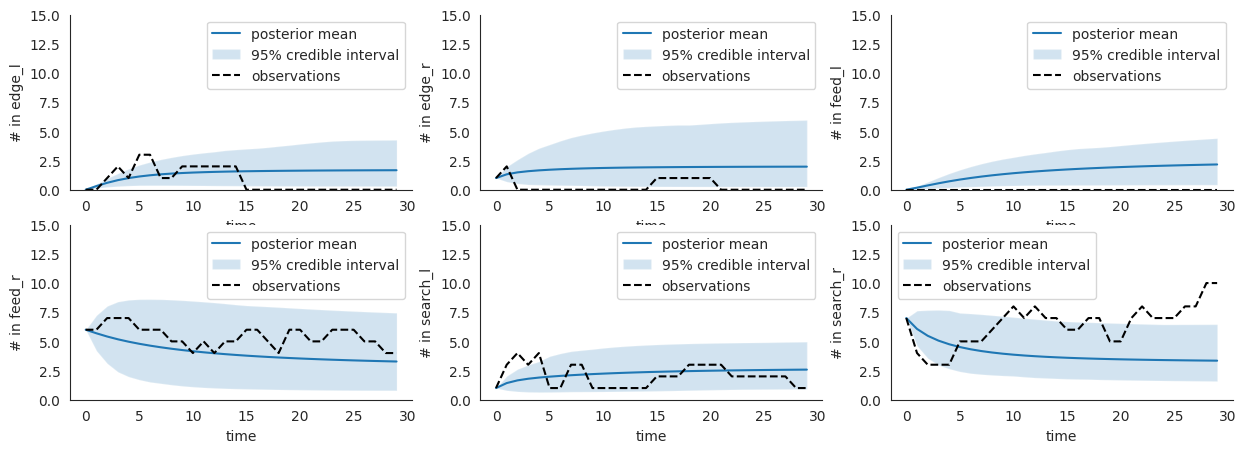

In [10]:
locds.posterior_check(samples = locds.v_samples, subset = locds.v_subset)

In [ ]:
def intervened_locust(
    intervention_starts,
    intervened_a_f,
    init_state,
    start_time,
    logging_times,
) -> State[torch.Tensor]:
    locust_model = lc.bayesian_locust(base_model=lc.LocustDynamics)
    with LogTrajectory(logging_times, is_traced=True) as lt_intervened:
        with TorchDiffEq():
            with StaticIntervention(
                time=intervention_starts, intervention=dict(a_f=intervened_a_f)
            ):
                simulate(locust_model, init_state, start_time, logging_times[-1])

    return lt_intervened.trajectory

In [ ]:
intervention_starts = 1
intervened_a_f = 0.0

intervened_locust_predictive = Predictive(
    intervened_locust, guide=real_locust_guide, num_samples=10
)
intervened_locust_posterior_samples = intervened_locust_predictive(
    intervention_starts,
    intervened_a_f,
    init_state,
    start_time,
    logging_times,
)